# Extended Kalman Filter Implementation
This notebook implements an Extended Kalman Filter (EKF) for orientation estimation based on the observations of gyroscopes, accelerometers, and magnetometers.

The EKF uses a quaternion-based representation to compute the orientation, incorporating both prediction and correction steps. The prediction step integrates gyroscope data, while the correction step utilizes accelerometer and magnetometer readings.

The mathematical foundations and details are based on the documentation provided.

In [41]:
import numpy as np
from scipy.linalg import expm

# Helper: Quaternion multiplication
def quaternion_multiply(q1, q2):
    """
    Multiply two quaternions.
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
        w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    ])

# Helper: Normalize quaternion
def normalize_quaternion(q):
    """
    Ensure the quaternion is normalized (unit norm).
    """
    return q / np.linalg.norm(q)

# Helper: Skew-symmetric matrix for cross products
def skew_symmetric(v):
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def quaternion_derivative_matrix(omega):
    """
    Calculate the quaternion derivative matrix.
    """
    return np.array([
        [0, -omega[0], -omega[1], -omega[2]],
        [omega[0], 0, omega[2], -omega[1]],
        [omega[1], -omega[2], 0, omega[0]],
        [omega[2], omega[1], -omega[0], 0]
    ])


## Prediction Step
The prediction step computes the next state based on the current state and angular velocity (gyroscope data). The quaternion state evolves using the following equation:

\[
q_{t} = q_{t-1} + \frac{\Delta t}{2} \cdot \Omega(\omega) q_{t-1}
\]

Where \( \Omega(\omega) \) is a matrix representation of angular velocity. This step ensures that the quaternion remains normalized.

In [42]:
def predict_state(q, omega, dt):
    """
    Predict the next quaternion state.
    """
    Omega = quaternion_derivative_matrix(omega)
    dq = 0.5 * Omega @ q * dt
    q_next = q + dq
    return normalize_quaternion(q_next)

## Measurement Update
The correction step adjusts the predicted quaternion based on accelerometer and magnetometer readings. It involves:

1. Calculating the predicted sensor values using the orientation quaternion.
2. Comparing predictions to actual measurements to compute the residual.
3. Updating the quaternion using the Kalman Gain.

The Kalman Gain \( K \) determines how much weight to give to the measurements versus the prediction.

In [ ]:
import numpy as np

def quaternion_to_rotation_matrix(q):
    """
    Convert a quaternion into a rotation matrix.
    
    Parameters:
    q (list or np.array): A quaternion [q0, q1, q2, q3] where q0 is the scalar part.
    
    Returns:
    np.array: A 3x3 rotation matrix.
    """
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])
    return R


def measurement_update(q, acc, mag, ref_acc, ref_mag, R):
    """
    Correct the quaternion using accelerometer and magnetometer measurements.
    """
    # Predicted values in sensor frame
    C = quaternion_to_rotation_matrix(q)  # From q to rotation matrix
    pred_acc = C.T @ ref_acc
    pred_mag = C.T @ ref_mag

    # Normalize measurements
    acc = acc / np.linalg.norm(acc)
    mag = mag / np.linalg.norm(mag)

    # Residual
    v_acc = acc - pred_acc
    v_mag = mag - pred_mag

    # Kalman Gain and state update (simplified for clarity)
    residual = np.hstack([v_acc, v_mag])
    K = np.linalg.pinv(R)  # Simplified computation
    q_corrected = q + K @ residual
    return normalize_quaternion(q_corrected)

In [35]:
import numpy as np

def quaternion_to_rotation_matrix(q):
    """
    Convert a quaternion into a rotation matrix.

    Parameters:
    - q: Quaternion [w, x, y, z]

    Returns:
    - R: 3x3 rotation matrix
    """
    qw, qx, qy, qz = q

    # Compute the rotation matrix elements
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])

    return R

def H_jacobian(q, g):
    """
    Compute the Jacobian matrix H of the measurement function h with respect to the state quaternion.

    Parameters:
    - q: State quaternion [w, x, y, z]
    - g: Gravity vector in ENU frame [gx, gy, gz]

    Returns:
    - H: 3x4 Jacobian matrix
    """
    qw, qx, qy, qz = q
    gx, gy, gz = g

    # Jacobian with respect to accelerometer prediction only
    H = np.zeros((3, 4))

    H[0, :] = 2 * np.array([
        gy * qz - gz * qy,
        gx * (-2 * qy) + gy * qw + gz * qz,
        -2 * gx * qy + gy * qz - gz * qw,
        -2 * gx * qz - gy * qy + gz * qx
    ])

    H[1, :] = 2 * np.array([
        gy * qw + gz * qx,
        gx * qy + gy * qx + gz * qz,
        gx * qx - gy * qw + gz * qz,
        gx * qz - gy * qx - gz * qw
    ])

    H[2, :] = 2 * np.array([
        -gx * qy + gy * qx,
        gx * qz + gy * qy - gz * qw,
        gx * qw - gy * qz + gz * qx,
        gx * qx + gy * qy - gz * qw
    ])

    return H

def normalize_quaternion(q):
    """
    Ensure the quaternion is normalized (unit norm).
    """
    return q / np.linalg.norm(q)

def measurement_update(q, acc, mag, ref_acc, ref_mag, R):
    """
    Correct the quaternion using accelerometer and magnetometer measurements.
    """
    # Predicted values in sensor frame
    C = quaternion_to_rotation_matrix(q)  # From q to rotation matrix
    pred_acc = C.T @ ref_acc
    pred_mag = C.T @ ref_mag

    # Normalize measurements
    acc = acc / np.linalg.norm(acc)
    mag = mag / np.linalg.norm(mag)

    # Residual
    v_acc = acc - pred_acc
    v_mag = mag - pred_mag

    # Stack residuals
    residual = np.hstack([v_acc, v_mag])

    # Jacobian matrix
    H_acc = H_jacobian(q, ref_acc)
    H_mag = H_jacobian(q, ref_mag)
    H = np.vstack([H_acc, H_mag])

    # Kalman Gain
    K = np.linalg.pinv(H.T @ np.linalg.pinv(R) @ H) @ H.T @ np.linalg.pinv(R)

    # State update
    q_corrected = q + K @ residual
    return normalize_quaternion(q_corrected)

In [36]:
def quaternion_to_rotation_matrix(q):
    """
    Convert a quaternion into a rotation matrix.

    Parameters:
    - q: Quaternion [w, x, y, z]

    Returns:
    - R: 3x3 rotation matrix
    """
    qw, qx, qy, qz = q

    # Compute the rotation matrix elements
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])

    return R


## Noise Models and Initialization
The noise models are derived from sensor characteristics and are critical for tuning the EKF. Typically, the process noise \( Q \) and measurement noise \( R \) are diagonal matrices based on the sensors' specifications.

In [37]:
def initialize_filter():
    """
    Initialize the filter with default parameters.
    """
    # Example initial quaternion (identity rotation)
    q_init = np.array([1.0, 0.0, 0.0, 0.0])

    # Example noise covariance matrices
    Q = np.eye(4) * 0.01  # Process noise
    R = np.eye(6) * 0.1   # Measurement noise (3 for acc + 3 for mag)

    return q_init, Q, R

## Main EKF Function
The main function integrates the prediction and correction steps for each time step. It takes sensor data as input and outputs the estimated orientation.

In [38]:
def ekf_loop(gyro_data, acc_data, mag_data, dt, ref_acc, ref_mag):
    """
    Main EKF loop.
    """
    q, Q, R = initialize_filter()
    estimated_quaternions = []

    for i in range(len(gyro_data)):
        # Prediction
        q = predict_state(q, gyro_data[i], dt)
        # Correction
        q = measurement_update(q, acc_data[i], mag_data[i], ref_acc, ref_mag, R)
        estimated_quaternions.append(q)

    return np.array(estimated_quaternions)

In [39]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function-based EKF implementation assumed to be already defined.
# Assuming `predict_state` and `measurement_update` from the earlier cells.

def ekf_loop(gyro_data, acc_data, mag_data, dt, ref_acc, ref_mag):
    """
    Main EKF loop.
    """
    # Initialize filter
    q = np.array([1.0, 0.0, 0.0, 0.0])  # Identity quaternion
    R = np.eye(6) * 0.1  # Measurement noise covariance
    estimated_quaternions = []

    for i in range(len(gyro_data)):
        # Prediction
        q = predict_state(q, gyro_data[i], dt)
        # Correction
        q = measurement_update(q, acc_data[i], mag_data[i], ref_acc, ref_mag, R)
        estimated_quaternions.append(q)

    return np.array(estimated_quaternions)

# Preprocessing data
data = pd.read_csv('data/train.csv')
time = data['Time'].values
dt = time[1] - time[0]  # Assuming uniform sampling interval

# Convert and calibrate sensor data
gyro_data = data[['GyroX', 'GyroY', 'GyroZ']].values * np.pi / 180
acc_data = data[['AccX', 'AccY', 'AccZ']].values * 9.81
mag_data = data[['MagX', 'MagY', 'MagZ']].values / 100

num_stationary_samples = 1000
gyro_bias = np.mean(gyro_data[:num_stationary_samples], axis=0)
gyro_data -= gyro_bias

acc_bias = np.mean(acc_data[:num_stationary_samples], axis=0) - np.array([0, 0, 9.81])
acc_data -= acc_bias

# Reference vectors
ref_acc = np.array([0, 0, 9.81])
ref_mag = np.array([1, 0, 0])  # Example reference magnetic field in the global frame

# Run EKF
quaternions = ekf_loop(gyro_data, acc_data, mag_data, dt, ref_acc, ref_mag)

# Convert quaternions to Euler angles
def quaternion_to_euler(q):
    w, x, y, z = q
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

euler_angles = np.array([quaternion_to_euler(q) for q in quaternions])
np.savetxt("orientation_test_output.csv", euler_angles, delimiter=",", header="roll,pitch,yaw", comments="")

MSE for Roll: 6478.713040699431
MSE for Pitch: 838.8523460172736
MSE for Yaw: 6491.145757544019


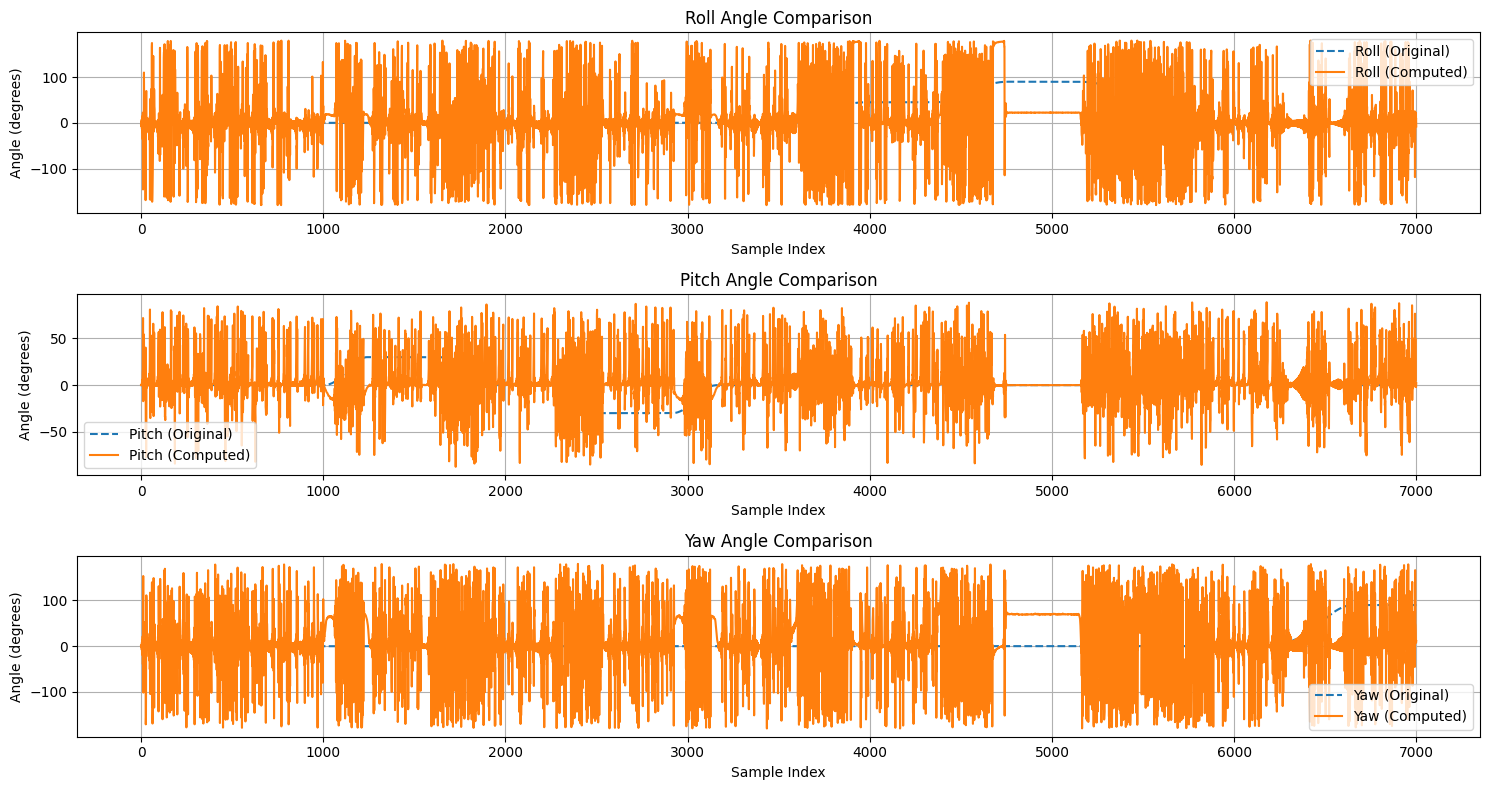

In [40]:

def plot_and_evaluate(original_csv, computed_csv):
    """
    Plot and evaluate EKF results.
    """
    # Load datasets
    original = pd.read_csv(original_csv)
    computed = pd.read_csv(computed_csv, names=["roll", "pitch", "yaw"], skiprows=1)
    
    roll_original, pitch_original, yaw_original = original['roll'], original['pitch'], original['yaw']
    roll_computed, pitch_computed, yaw_computed = computed['roll'], computed['pitch'], computed['yaw']
    
    # Calculate MSE
    mse_roll = mean_squared_error(roll_original, roll_computed)
    mse_pitch = mean_squared_error(pitch_original, pitch_computed)
    mse_yaw = mean_squared_error(yaw_original, yaw_computed)

    print(f"MSE for Roll: {mse_roll}")
    print(f"MSE for Pitch: {mse_pitch}")
    print(f"MSE for Yaw: {mse_yaw}")

    # Plot comparisons
    plt.figure(figsize=(15, 8))
    plt.subplot(3, 1, 1)
    plt.plot(roll_original, label='Roll (Original)', linestyle='--')
    plt.plot(roll_computed, label='Roll (Computed)')
    plt.title('Roll Angle Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(pitch_original, label='Pitch (Original)', linestyle='--')
    plt.plot(pitch_computed, label='Pitch (Computed)')
    plt.title('Pitch Angle Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(yaw_original, label='Yaw (Original)', linestyle='--')
    plt.plot(yaw_computed, label='Yaw (Computed)')
    plt.title('Yaw Angle Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Example usage
plot_and_evaluate("data/train.csv", "orientation_test_output.csv")